In [14]:
#import packages
from nipype.interfaces.io import DataSink, SelectFiles, DataGrabber # Data i/o
from nipype.interfaces.utility import IdentityInterface, Function     # utility
from nipype.pipeline.engine import Node, Workflow, MapNode, JoinNode        # pypeline engine
from pandas import DataFrame, Series,read_csv

#set output file type for FSL to NIFTI_GZ
from nipype.interfaces.fsl.preprocess import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# Set study variables
setup='Cat'
sample='newborn' #6mo or newborn

if setup=='Marissa':
    studyhome = '/Volumes/SEALab_Projects/BABIES/MRI/Newborn_BIDS'  #update if 6-month old
    raw_data = studyhome + '/raw'
    output_dir = studyhome + '/proc/preproc'
    workflow_dir = studyhome + '/workflows' 
    templates = studyhome + '/templates'
elif setup=='Cat':
    studyhome = '/home/camachocm2/Analysis/SEA/rest_proc'
    raw_data = studyhome + '/raw/raw_func'
    preproc_dir = studyhome + '/processed/preproc'
    output_dir = studyhome + '/processed/network_analysis_combROI'
    workflow_dir = studyhome + '/workflows'
    templates = studyhome + '/templates'
    subjects_info = read_csv(studyhome + '/misc/subject_info.csv',index_col=None, dtype={'subject_id':str})

subjects_list = subjects_info['subject_id'].tolist()

template_atlas = studyhome + '/rois/amyg_pfc_comb_rois.nii.gz'
template_atlas_key = studyhome + '/rois/amyg_pfc_comb_rois_key.csv'

proc_cores = 6 # number of cores of processing for the workflows

In [15]:
def correlation_matrix(func,atlas,atlas_labels):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    from nilearn.input_data import NiftiLabelsMasker
    from nilearn.connectome import ConnectivityMeasure
    from nilearn import plotting
    from pandas import read_csv, DataFrame
    import matplotlib.pyplot as plt

    labels_df = read_csv(atlas_labels, index_col=None)
    labels = labels_df['region_name']
    masker = NiftiLabelsMasker(labels_img=atlas, standardize=True)
    time_series = masker.fit_transform(func)

    correlation_measure = ConnectivityMeasure(kind='correlation')
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    corr_mat_df = DataFrame(correlation_matrix,columns=labels,index=labels)
    corr_mat_df.to_csv('correlation_matrix.csv')

    plt.figure()
    plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                         vmax=0.8, vmin=-0.8, reorder=True)
    plt.savefig('corr_matrix.svg')
    plt.close()
    
    corr_mat_fig = abspath('corr_matrix.svg')
    corr_matrix = abspath('correlation_matrix.csv')
    
    return(corr_matrix, corr_mat_fig)

In [16]:
## File handling Nodes

# Identity node- select subjects
infosource = Node(IdentityInterface(fields=['subject_id']),
                     name='infosource')
infosource.iterables = ('subject_id', subjects_list)

# Datasink- where our select outputs will go
substitutions = [('_subject_id_', '')]
datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir
datasink.inputs.substitutions = substitutions

# Data grabber
file_template = {'func': preproc_dir + '/fully_processed_func/{subject_id}/final_proc_func.nii.gz'}
selectfiles = Node(SelectFiles(file_template), name='selectfiles')

calc_connectivity = Node(Function(input_names=['func','atlas','atlas_labels'], 
                                  output_names=['corr_matrix','corr_mat_fig'], 
                                  function=correlation_matrix), 
                         name='calc_connectivity')
calc_connectivity.inputs.atlas = template_atlas
calc_connectivity.inputs.atlas_labels = template_atlas_key

In [ ]:
connect_flow = Workflow(name='connect_flow')
connect_flow.connect([(infosource,selectfiles, [('subject_id','subject_id')]),
                      (selectfiles, calc_connectivity, [('func','func')]),
                      
                      (calc_connectivity, datasink, [('corr_matrix','correlation_matrix'),
                                                     ('corr_mat_fig','corr_matrix_plot')])
                     ])

connect_flow.base_dir = workflow_dir
connect_flow.write_graph(graph2use='flat')
connect_flow.run('MultiProc', plugin_args={'n_procs': 4, 'memory_gb':30})

<Figure size 432x288 with 0 Axes>

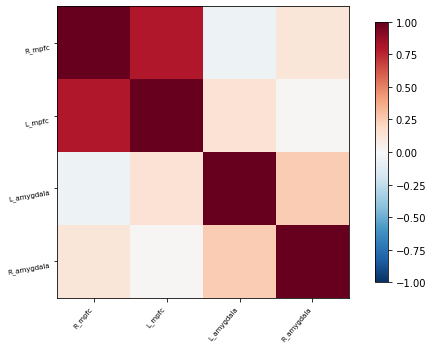

In [22]:
from nilearn import plotting
from pandas import read_csv, DataFrame
import matplotlib.pyplot as plt
import numpy as np

labels_df = read_csv(template_atlas_key, index_col=None)
labels = labels_df['region_name']

group_conn_data = read_csv(output_dir + '/correlation_matrix/{0}/correlation_matrix.csv'.format(subjects_list[0]), index_col=0)
group_conn_mat = group_conn_data.to_numpy()
group_conn_mat = np.expand_dims(group_conn_mat, axis=2)

for sub in subjects_list[1:]:
    temp = read_csv(output_dir + '/correlation_matrix/{0}/correlation_matrix.csv'.format(sub), index_col=0)
    temp_mat = np.expand_dims(temp.to_numpy(),axis=2)
    group_conn_mat = np.concatenate((group_conn_mat,temp_mat),axis=2)

mean_conn_data = np.average(group_conn_mat,axis=2)


plt.figure()
plotting.plot_matrix(mean_conn_data, figure=(6, 6), labels=labels,
                     vmax=1, vmin=-1,reorder=True)
plt.savefig(output_dir+'/group_mean_combpfc_corr_matrix.png')
plt.show()
plt.close()